In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

from functools import partial
import itertools as it

import pandas as pd
import numpy as np
import datetime as dt
import os, sys

from pathlib import Path

import torch
import ray
from ray import train, tune

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm

from src.datasets import daocensus

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
TRANSFORMER_MODEL = "all-mpnet-base-v2"
ORG_NAME = 'Decentraland'

# Evaluation
# N_SPLITS: int = 10
# SKIP_SPLIT: int = 0
K_RECOMMENDATIONS: List[int] = [5, 10]
SPLITS_FREQ: str = '1W' # split weekly
LAST_SPLITS = 10 # Use just last 10 splits

# k for K Nearest Neighbors
# KNN_K: int = 1

In [3]:
dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
dfv['voter'] = dfv['voter'].astype('str')
dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
print(dfv.info())
print(dfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(7)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942 entries, 0 to 1941
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------ 

## Getting the embeddings of each proposal

In [4]:
from sentence_transformers import SentenceTransformer
import pickle

In [5]:
model = SentenceTransformer(TRANSFORMER_MODEL)

In [6]:
embeddings_folder = Path('./data/daos-census-text')
embeddings_file = embeddings_folder / 'embeddings.pkl'

dfp['title-description'] = dfp['title'] + '\n' + dfp['description']

if not embeddings_folder.exists():
    embeddings_folder.mkdir()

embeddings = None
if embeddings_file.exists():
    print('Embeddings file saved, reading it instead...')
    with open(embeddings_file, 'rb') as f:
        obj = pickle.load(f)
    
    embeddings = obj['embeddings']
    print("Embeddings shape:", embeddings.shape)
    ids = obj['ids']

if embeddings is None:
    embeddings = model.encode(dfp['title-description'], show_progress_bar=True, normalize_embeddings=True)
    with open(embeddings_file, 'wb+') as f:
        pickle.dump({'sentences': dfp['title-description'], 'embeddings': embeddings, 'ids': dfp['id']}, f, protocol=pickle.HIGHEST_PROTOCOL)
    ids = dfp['id']

Embeddings file saved, reading it instead...
Embeddings shape: (1942, 768)


In [7]:
embeddings_sum = embeddings.sum(axis=0)
print(embeddings_sum.shape)
embeddings = embeddings / embeddings_sum
embeddings

(768,)


array([[ 1.1403942e-03,  8.6159667e-04,  6.9543906e-04, ...,
        -2.7190472e-03, -1.0145850e-03,  3.9847512e-03],
       [-4.0623921e-04,  4.4145260e-04,  9.4736629e-04, ...,
         1.6015386e-03,  1.8749244e-03, -2.8607671e-04],
       [ 2.3584028e-03,  5.8685098e-04,  7.1522983e-04, ...,
        -2.2754685e-03, -1.4056198e-04, -3.7364415e-03],
       ...,
       [ 7.4751978e-04,  6.6007749e-04,  6.3091848e-04, ...,
         2.4024327e-03, -2.0156235e-03,  3.5178075e-03],
       [ 1.0567971e-03,  4.8019559e-05,  3.8508393e-04, ...,
        -2.2719151e-04,  3.0133147e-03, -4.8025078e-03],
       [-7.7102036e-04,  5.3977495e-04,  6.2477670e-04, ...,
         4.1932142e-03, -3.2050564e-05,  5.8417697e-03]], dtype=float32)

In [8]:
dfp['embeddings'] = list(embeddings)

## Getting the embeddings of each user

The embeddings of each user are the embeddings of each proposal the user has voted in

In [9]:
dfp['nbidx'] = dfp.index
_dfv = dfv.merge(dfp[['id', 'nbidx']], how='left', left_on='proposal', right_on='id')
print('dfp:', dfp.shape, 'dfv:', dfv.shape, '_dfv:', _dfv.shape)
votes_embeddings = embeddings[_dfv['nbidx']]
votes_embeddings.shape

dfp: (1942, 17) dfv: (116560, 10) _dfv: (116560, 12)


(116560, 768)

In [10]:
x=np.array([3,4])
x = x / np.linalg.norm(x)
print(x)
print(np.linalg.norm(x))
print(x.sum())

[0.6 0.8]
1.0
1.4


In [11]:
voter_embeddings = dfv.groupby('voter').apply(lambda x: votes_embeddings[x.index].sum(axis=0))
voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
# msk = (np.linalg.norm(np.stack(voter_embeddings.to_numpy()), axis=1) > 0.9)
voter_embeddings

voter
0x0019220ddabe5b8438a6be6ebca31ef01ca69965    [0.0005797436, 0.0008813106, 0.0009436921, 0.0...
0x0023a0bf1cb20362f847dfc977d2c815f6ac8021    [0.0058569475, 0.0020814762, 0.0020506687, 0.0...
0x0026dd985da16f70e9d9cf739b08c6cdf6a7f407    [0.00049382605, 0.000369442, 0.0001715262, 0.0...
0x0029ab135b5be72168bf80f140d60a9264dbd0c5    [0.0015583907, 0.0006184035, 0.0007542482, 0.0...
0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34    [0.0029788632, 0.0022017027, 0.0020975238, 0.0...
                                                                    ...                        
0xffd92144cafd599a5a93e4805ca4d8f0e666d623    [0.0018572637, 0.0015811239, 0.0013924055, 0.0...
0xffd9cd75445459184a4b89a0fbd1720ab2957738    [0.001981472, 0.0022674527, 0.0011901953, 0.00...
0xffe6d9d29480d0673c4fc46da22d21e245c8e731    [0.0024959077, 0.0013624564, 0.0004591559, 0.0...
0xffed2f64c9f796d4258618a7a375ed816205821a    [-0.00015786002, 0.0002711929, 0.0002997918, 8...
0xfff28923092a8294456206a6d0734514

In [12]:
dfv.groupby('voter').size().sort_values()

voter
0x7dc3331bc545a41e566dfbbb3d8851bf4762486f      1
0x7ae0a65d329bc202e83a360d9afc880063c12337      1
0x7b07608c3e4ef235c7a5e15f02a7fa9552ce113f      1
0x7b29be2f106712287024e6228e015d44cdfa0dec      1
0x7b2ec1a291a0a4dd08d65ab34a62bda1cca618c6      1
                                             ... 
0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8    652
0xd6eff8f07caf3443a1178407d3de4129149d6ef6    727
0xb44ac514588be99870220d12120815bc3d349507    729
0x521b0fef9cdcf250abaf8e7bc798cbe13fa98692    760
0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb    885
Length: 7268, dtype: int64

## Making recommendations with cosine similarity

Because they are normalized, our ranking score can be just the dot product of a user and a proposal

In [13]:
user_emb = voter_embeddings['0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8']
scores = embeddings @ user_emb
scores.argsort()

array([ 324,  940,  320, ...,  413, 1134,  457])

In [14]:
list(range(10))[-3:]

[7, 8, 9]

In [15]:
def recommend_emb(emb, k, t = None):
    """
    Args:
        emb: The embedding of the item/user to recommend items to
        k (int): The number of items to recommend
        t (timestamp): Simulate that the recommendation is made at time `t`
            i.e: Filter out already closed proposals or not yet open
    """
    # 1D n_proposals
    scores = embeddings @ emb

    if t:
        msk = (dfp['start'] < t) & (t < dfp['end'])
        scores[msk] = -np.inf
    
    best = (-scores).argsort()

    dfbest = dfp.iloc[best[:k]].copy()
    dfbest['score'] = scores[best[:k]]
    return dfbest

In [16]:
def recommend_user(voter: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    user_emb = voter_embeddings[voter]
    return recommend_emb(user_emb, k, t)

recommend_user('0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8')[['title', 'description', 'score']]

,title,description,score
457,Logarithmic VP conversion after a certain amou...,> by 0x5985eb4a8e0e1f7bca9cc0d7ae81c2943fb205b...,6.910858
1134,Should Voter Power Delegation be activated in ...,> by 0x9982b469910c2ee2ea566dcfcc250cdd3405639...,5.948124
413,Can we implement 'R' and 'G' keys to allow for...,> by 0xb2223f4038def8a62a86e3c4b108cdfe00a74c4...,5.480871
873,Should VP keep assigned to the landowner in a ...,> by 0x87956abc4078a0cc3b89b419928b857b8af826e...,5.170687
1736,Create Group Chats between Mutual Friends,> by 0x988262eb3225ea4690f6b4846e36c700345bf6f...,4.964846


In [17]:
def recommend_proposal(proposal: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    prop_emb = dfp.set_index('id')['embeddings'][proposal]
    return recommend_emb(prop_emb, k, t)

display(dfp.set_index('id').loc['433b7e43-77b0-5ea1-bac3-0c3071363a56'])
recommend_proposal('433b7e43-77b0-5ea1-bac3-0c3071363a56')

platform                                                        snapshot
name                                                        Decentraland
platform_deployment                                     snapshot.dcl.eth
deployment                          41fd8de5-f8e2-5023-86a3-825c49e9ad7f
platform_proposal      0xdbe9b2df1d00c0d264bffb3f10f1332a82d8a8a70c12...
author                        0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69
date                                                 2023-02-14 16:19:06
votes_count                                                          385
proposal_id            0xdbe9b2df1d00c0d264bffb3f10f1332a82d8a8a70c12...
title                  Should DAO proposals have a pre-defined 'Absta...
description            > by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...
start                                                2023-02-14 16:19:00
end                                                  2023-02-28 16:19:00
title-description      Should DAO proposals have a 

,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,votes_count,proposal_id,title,description,start,end,title-description,embeddings,nbidx,score
940,snapshot,Decentraland,snapshot.dcl.eth,5f8989a6-464f-57ef-bbee-74f3ce8b001f,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmcY88YFJLgiMatBPD1j9KUxBwPhymW5DdVP4JQDj53jYr,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2021-12-23 22:13:33,14,QmcY88YFJLgiMatBPD1j9KUxBwPhymW5DdVP4JQDj53jYr,Petition to add event reviews so we can improv...,> by 0xbef69e080a0b127f7cf6f3b658f07c90588cea6...,2021-12-23 22:13:00,2021-12-30 22:13:00,Petition to add event reviews so we can improv...,"[-0.0015171164, 0.0007642187, 0.00042039528, 0...",940,2.342395
1537,snapshot,Decentraland,snapshot.dcl.eth,613dbb55-2dd7-51fc-a289-c1a39a6461ff,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,0xfad0ce3f336f9104fd8d5cc2cb3c012c21a2116d7f7b...,0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69,2023-03-06 20:56:57,96,0xfad0ce3f336f9104fd8d5cc2cb3c012c21a2116d7f7b...,Community support for a paid pre-check on link...,> by 0x895be97bdb9f8a244c472b18ea96dee39ddf8fe...,2023-03-06 20:56:00,2023-03-11 20:56:00,Community support for a paid pre-check on link...,"[-0.00037167242, 0.00045459915, 8.636677e-05, ...",1537,2.168351
1644,snapshot,Decentraland,snapshot.dcl.eth,a7eabea1-95b5-5621-8bc5-8f09f313c45e,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,bafkreidmcnjlewiwuvyty5k2atld2qtnesk5dky2gwhwo...,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2022-09-07 15:39:27,92,bafkreidmcnjlewiwuvyty5k2atld2qtnesk5dky2gwhwo...,Should there be limited time to change voting ...,> by 0x247e0896706bb09245549e476257a0a1129db41...,2022-09-07 15:39:00,2022-09-12 15:39:00,Should there be limited time to change voting ...,"[0.00034874497, 0.00051068235, 0.00022908037, ...",1644,2.036432
1242,snapshot,Decentraland,snapshot.dcl.eth,5be72d6c-2388-5aaa-8ac6-20be847a82cc,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,0xdce2b640a47ba0c44bfa9e9a88ad8bffb9a5a3ffbff5...,0xbb7b59afa3a0e5be143b8fe9c641f00c1ecb9d69,2023-01-06 17:54:38,201,0xdce2b640a47ba0c44bfa9e9a88ad8bffb9a5a3ffbff5...,Should DAO proposals have a pre-defined 'Absta...,> by 0x511a22cdd2c4ee8357bb02df2578037ffe8a4d8...,2023-01-06 17:54:00,2023-01-11 17:54:00,Should DAO proposals have a pre-defined 'Absta...,"[-0.0007028324, 0.0001626759, -7.843193e-06, -...",1242,2.001611
1149,snapshot,Decentraland,snapshot.dcl.eth,62662ecc-3126-5798-bbd9-b1421082be58,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,QmVCfrGX892iaDLkp5dBNJRa93U2DVbg3JNcD14mfGvMS1,0x5e23d08324f017d5425e59a2782c9ae27ace0958,2022-05-19 23:18:01,161,QmVCfrGX892iaDLkp5dBNJRa93U2DVbg3JNcD14mfGvMS1,MANA incentives for USDC-ICE LP on QuickSwap,> by 0x521b0fef9cdcf250abaf8e7bc798cbe13fa9869...,2022-05-19 23:18:00,2022-05-24 23:18:00,MANA incentives for USDC-ICE LP on QuickSwap\n...,"[0.0009039452, 0.00047539602, 0.0006336307, 0....",1149,1.982089


### Evaluation

First, we will evaluate if the user recommendations are any good using common off-line metrics.

In [23]:
def recommendNLPNaive(train: pd.DataFrame, users, proposals, k: int = 5, remove_training: bool = True, min_score: float = 0):  
    # Create voter embeddings (filtering that they are in train)
    # TODO: Add some kind of discount rate over time
    # TODO: DELETEME
    aux = dfv[dfv['voter'].isin(users) & dfv['proposal'].isin(train['itemID'])]
    not_in_train = set(users).difference(dfv[dfv['proposal'].isin(train['itemID'])]['voter'])
    print('aux.shape:', aux.shape)
    print('not in train (in):', len(not_in_train))

    voter_embeddings = aux.groupby('voter').apply(lambda x: votes_embeddings[x.index].sum(axis=0))
    voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
    np_voter_embeddings = np.stack(voter_embeddings.to_numpy())
    
    # Remove score from proposals not in `proposals`
    msk = ids.isin(proposals)
    tr_embeddings = embeddings.copy()
    tr_embeddings[~msk] = 0
    
    scores = np_voter_embeddings @ tr_embeddings.T
    
    # Remove score from proposals already voted by user
    if remove_training:
        trainu = train[train['userID'].isin(users)]
        itemID2idx = dfp.set_index('id')['nbidx']
        voterID2idx = pd.Series(data=np.arange(len(voter_embeddings)), index=voter_embeddings.index)
        scores[voterID2idx[trainu['userID']], itemID2idx[trainu['itemID']]] = -np.inf
        
    best = (-scores).argsort(axis=1)
    topk = best[:, :k]
    
    # create df with columns
    # userID, itemID, prediction
    uid = np.repeat(np.arange(np_voter_embeddings.shape[0]), k)
    iid = topk.flatten()
    
    # transform int to id
    df = pd.DataFrame({
        'userID': voter_embeddings.index[uid],
        'itemID': ids[iid].astype(str),
        # 'prediction': 1,
        'prediction': scores[uid, iid],
    })
    return df[df['prediction'] > min_score].reset_index(drop=True)

# train = train_filtered
# users = test_filtered['userID'].unique()
# proposals = test_filtered['itemID'].unique()
# k = 3
# remove_training = True

In [24]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from src.datasets import to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent

In [25]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

### Evaluation in multiple months

In [28]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, remove_not_in_train_col='userID'))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsSimilarity(fold, window_size):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)

    train_filtered = train[train['timestamp'] > (t - offset)]
    not_in_train = set(test['userID']).difference(train['userID'])
    print('not in train:', len(not_in_train))
    print('not in train filtered:', len(not_in_train))
    for k_recs in K_RECOMMENDATIONS:
        recs = recommendNLPNaive(train_filtered, test['userID'].unique(), open_proposals, k_recs)

        for m, f in metrics_f.items():
            metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

testHParamsSimilarity(0, '14d')
testHParamsSimilarity(1, '2W')

not in train: 0
not in train filtered: 0
aux.shape: (1755, 10)
not in train (in): 0
aux.shape: (1755, 10)
not in train (in): 0
not in train: 0
not in train filtered: 0
aux.shape: (1257, 10)
not in train (in): 0
aux.shape: (1257, 10)
not in train (in): 0


{'precision@5': 0.30681818181818177,
 'ndcg@5': 0.6699651194186544,
 'map@5': 0.5605176767676768,
 'precision@10': 0.1954545454545455,
 'ndcg@10': 0.6989476039316732,
 'map@10': 0.5971013332732084}

In [22]:
from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '1M', '3M', '6M', '12M', '10Y'],
})

results = list()
for p in tqdm(param_grid):
    results.append(testHParamsSimilarity(**p) | p)

mdf = pd.DataFrame(results).set_index(['fold', 'window_size'])
mdf

  0%|          | 0/70 [00:00<?, ?it/s]

precision@5    ndcg@5     map@5  precision@10   ndcg@10  \
fold window_size                                                            
0    7d              0.278261  0.614565  0.483801      0.201449  0.652292   
     14d             0.268148  0.521153  0.392121      0.185185  0.546187   
     1M              0.278261  0.614565  0.483801      0.201449  0.652292   
     3M              0.245926  0.457144  0.329056      0.168889  0.477452   
     6M              0.242963  0.447541  0.321161      0.162222  0.460159   
...                       ...       ...       ...           ...       ...   
9    1M              0.274194  0.486490  0.345822      0.199597  0.545022   
     3M              0.266129  0.468681  0.340316      0.197581  0.526722   
     6M              0.253226  0.429839  0.307202      0.191532  0.491146   
     12M             0.250000  0.416151  0.294705      0.189113  0.479762   
     10Y             0.242742  0.400275  0.283325      0.183468  0.462691   

                    map@10  
fold window_size            
0    7d           0.529758  
     14d          0.430784  
     1M           0.529758  
     3M           0.361888  
     6M           0.349371  
...                    ...  
9    1M           0.399206  
     3M           0.390450  
     6M           0.357308  
     12M          0.346156  
     10Y          0.332969  

[70 rows x 6 columns]

<Axes: xlabel='fold', ylabel='precision@5'>

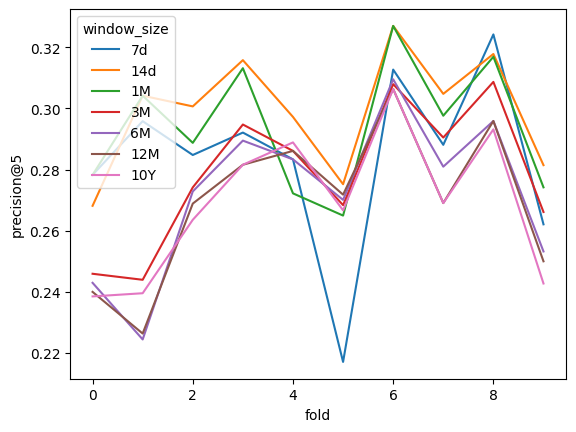

In [23]:
sns.lineplot(mdf, x='fold', y='precision@5', hue='window_size')

In [24]:
mdf.groupby('window_size').describe().T

window_size               10Y        12M        14d         1M         3M  \
precision@5  count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.269008   0.269602   0.299221   0.293720   0.278650   
             std     0.023693   0.024927   0.019177   0.021292   0.023023   
             min     0.238519   0.226374   0.268148   0.264957   0.243956   
             25%     0.247950   0.254719   0.285394   0.275210   0.266691   
             50%     0.267857   0.270421   0.302414   0.293180   0.280142   
             75%     0.287061   0.284978   0.313033   0.310910   0.293672   
             max     0.306349   0.306349   0.326984   0.326984   0.308676   
ndcg@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.458752   0.463506   0.541977   0.538408   0.486397   
             std     0.049151   0.045278   0.069920   0.083054   0.050630   
             min     0.390857   0.401073   0.414179   0.381226   0.395210   
             25%     0.433013   0.433056   0.520529   0.491966   0.464422   
             50%     0.452688   0.457467   0.527504   0.536865   0.481356   
             75%     0.481721   0.490267   0.560081   0.582646   0.496597   
             max     0.535250   0.543760   0.685100   0.685100   0.580860   
map@5        count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.342768   0.347202   0.416376   0.412127   0.366720   
             std     0.056130   0.055264   0.074503   0.089317   0.055516   
             min     0.280087   0.288349   0.305712   0.266368   0.289087   
             25%     0.305833   0.303727   0.377599   0.354420   0.331593   
             50%     0.324186   0.331469   0.398431   0.403816   0.352959   
             75%     0.375509   0.384059   0.434745   0.469163   0.385887   
             max     0.434220   0.440185   0.579780   0.579780   0.472040   
precision@10 count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.188005   0.189556   0.205887   0.206610   0.196218   
             std     0.031563   0.033175   0.024721   0.024432   0.029858   
             min     0.138462   0.137363   0.168056   0.166667   0.153846   
             25%     0.166404   0.166404   0.191009   0.193452   0.173048   
             50%     0.183401   0.188604   0.199606   0.200523   0.195814   
             75%     0.209521   0.210360   0.224552   0.220212   0.219065   
             max     0.241270   0.245238   0.251587   0.253968   0.245238   
ndcg@10      count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.511695   0.518983   0.595547   0.598725   0.544621   
             std     0.047311   0.051546   0.062471   0.069474   0.052611   
             min     0.443435   0.440687   0.514310   0.494238   0.477452   
             25%     0.485178   0.493459   0.549157   0.545338   0.507077   
             50%     0.510014   0.513226   0.583834   0.607998   0.541485   
             75%     0.532182   0.531080   0.621335   0.643763   0.564275   
             max     0.613972   0.635583   0.713209   0.713209   0.663968   
map@10       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.393690   0.399681   0.470925   0.469836   0.421400   
             std     0.048863   0.051860   0.066825   0.079263   0.051556   
             min     0.332969   0.331101   0.395272   0.361578   0.361888   
             25%     0.363473   0.368340   0.427329   0.401024   0.389832   
             50%     0.396178   0.403672   0.452905   0.475372   0.411154   
             75%     0.403083   0.409963   0.490713   0.520547   0.434920   
             max     0.490991   0.510802   0.614617   0.614617   0.537577   

window_size                6M         7d  
precision@5  count  10.000000  10.000000  
             mean    0.272274   0.283849  
             std     0.025720   0.029159  
             min     0.224444   0.217094  
           

In [25]:
bdf = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')[-10:]
bdf.describe()

,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10,precision@15,ndcg@15,map@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.213742,0.313582,0.234635,0.196668,0.427430,0.317053,0.170245,0.498809,0.355657
std,0.039104,0.068296,0.061831,0.027190,0.075479,0.068092,0.022517,0.065520,0.061382
min,0.162162,0.221889,0.153784,0.154167,0.309380,0.212023,0.145045,0.375595,0.246974
25%,0.173611,0.249705,0.180593,0.175694,0.376838,0.270741,0.149419,0.479367,0.326162
50%,0.228711,0.318409,0.238679,0.200820,0.440287,0.334424,0.170887,0.508876,0.372283
75%,0.237616,0.359613,0.267417,0.210291,0.478242,0.361431,0.178977,0.549092,0.395439
max,0.275000,0.406115,0.325226,0.234091,0.542648,0.409316,0.213333,0.573935,0.424232


# Second iteration: PLN with kNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

itemID2idx = dfp.set_index('id')['nbidx']

In [27]:
def filter_proposals_in_train(train, user, proposals):
    msk = train['userID'] == user
    proposals_aready_voted_by_user = train[msk]['itemID'].unique()
    return np.setdiff1d(proposals, proposals_aready_voted_by_user)

In [28]:
def recommendUserKNN(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, knn_k = 3, do_sampling: Optional[bool] = None, remove_train: bool = True, metric=None):
    """
    Given the train data (proposals that might be voted or not by the user), recommend k proposals from proposals to the user
    The train data is a DataFrame in microsoft's format
    
    do_sampling (bool) : default None
        if True, makes sampling so the number of positive and negative samples is the same
        if False, doesn't do it
        if None (default), does it when k > 1, but doesn't do it with Nearest Neighbor
    """
    # train['hasVoted'] = train['userID'] == user
    hasVoted = train['userID'] == user

    # Remove recommendations already in training
    # (aka remove from proposals array)
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)

    assert any(hasVoted), 'The user has not voted in any proposal'

    if do_sampling or (do_sampling is None and knn_k > 1):
        # num_samples = train['hasVoted'].value_counts().min() # [True]
        num_samples = hasVoted.value_counts().min() # [True]
        train = train.groupby(hasVoted).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
        hasVoted = train['userID'] == user
    
    known_embeds = embeddings[itemID2idx[train['itemID']]]

    assert knn_k >= 0
    knn = KNeighborsClassifier(max(knn_k, 1), metric=metric if metric else 'minkowski')
    knn.fit(known_embeds, hasVoted)# train['hasVoted'])

    predict_embeds = embeddings[itemID2idx[proposals]]
    aux = knn.predict_proba(predict_embeds)
    p = knn.predict_proba(predict_embeds)[:, 1] # Probabilidad de que sea True

    if top_k:
        best = (1-p).argsort()[:top_k]
        p = p[best]
        proposals = proposals[best]
    
    return pd.DataFrame({
        'userID': user,
        'itemID': proposals,
        'prediction': 1,
        'score': p,
    })

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# p = recommendUserKNN(train, u, test_filtered['itemID'].unique().copy(), 5, do_sampling=True)
# p['correct'] = p['itemID'].isin(proposals_voted_by_user['itemID'])
# p

In [29]:
from recommenders.datasets.pandas_df_utils import filter_by

def recommendMostVoted(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    df = pd.DataFrame({
        'userID': user,
        'itemID': bestVotes.index,
        'prediction': 1,
        'score': bestVotes,
    })
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    return df.head(top_k).reset_index(drop=True)

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# recommendMostVoted(train_filtered.copy(), u, test_filtered['itemID'].unique(), 5)

In [30]:
import multiprocessing as mp
from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool as Pool

def recommendUserKNNwithFallback(train, user, proposals, top_k = None, knn_k: int = 1, remove_train: bool = True, do_sampling = None, metric=None):
    """ If the user has not voted in any proposal in `train`, we fall back to recommending
    the most voted proposal in `proposals`
    """
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)
    if (user == train['userID']).sum() >= max(knn_k, 1):
        df = recommendUserKNN(train, user, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling, metric=metric)
        df['scoreType'] = 'knn'
        return df
    else:
        df = recommendMostVoted(train, user, proposals, top_k, remove_train=False)
        df['scoreType'] = 'mv'
        return df

def recommendNLPKNN(train: pd.DataFrame, users, proposals, top_k: int = 5, knn_k: int = 1, do_sampling=None, cpus=-1, chunksize=8, disable_tqdm=False, metric=None):
    # Create voter embeddings
    assert knn_k >= 0

    # return pd.concat(tqdm((
    #     recommendUserKNNwithFallback(train, u, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling) for u in users
    # ), desc='users', leave=False, total=len(users)))

    p = partial(
        recommendUserKNNwithFallback, 
        train, 
        proposals=proposals, 
        top_k=top_k,
        knn_k=knn_k,
        do_sampling=do_sampling,
        metric=metric,
    )

    if cpus == 1:
        return pd.concat(tqdm(
            map(p, users),
            total=len(users),
            desc='users',
            leave=False,
            disable=disable_tqdm,
        ))
    else:
        with Pool(mp.cpu_count() // 4 if cpus==-1 else cpus) as pool:
            return pd.concat(
                tqdm(
                    pool.imap(p, users, chunksize=chunksize),
                    total=len(users),
                    desc='users',
                    leave=False,
                    disable=disable_tqdm,
                )
            )

# recommendNLPKNN(train, test_filtered['userID'].unique(), test_filtered['itemID'].unique(), top_k=1)

In [31]:
print(mp.cpu_count())

24


### Evaluation

Usaremos el método del codo para ver cual de todos es mejor

In [32]:
import time

df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', return_open=True))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsKNN(fold, window_size, k, metric):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)
    train_filtered = train[train['timestamp'] > (t - offset)]

    for k_recs in K_RECOMMENDATIONS:
        time_start = time.time()
        recs = recommendNLPKNN(train_filtered, test['userID'].unique(), open_proposals, k_recs, k, cpus=1, disable_tqdm=True, metric=metric)
        time_end = time.time()

        metrics['time_s'] = time_end - time_start
        for m, f in metrics_f.items():
                metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

testHParamsKNN(0, '14d', 0, 'cosine')

{'time_s': 2.559751272201538,
 'precision@5': 0.16833333333333333,
 'ndcg@5': 0.21298160131445137,
 'map@5': 0.14031225053374172,
 'precision@10': 0.16999999999999998,
 'ndcg@10': 0.3247068715432085,
 'map@10': 0.21624785633692015}

In [33]:
from sklearn.model_selection import ParameterGrid
from tqdm.contrib.concurrent import thread_map as tqdm_map

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '1M', '3M', '6M', '12M', '10Y'],
    'k': range(10),
    'metric': ['minkowski', 'cosine'],
})

def retDict(p):
    return testHParamsKNN(**p) | p

results = tqdm_map(retDict, param_grid, chunksize=4, tqdm_class=tqdm)
mdf = pd.DataFrame(results).set_index(['fold', 'window_size', 'k', 'metric'])
mdf.to_pickle('mdf.pkl')
mdf

  0%|          | 0/1400 [00:00<?, ?it/s]

time_s  precision@5    ndcg@5     map@5  \
fold window_size k metric                                                    
0    7d          0 minkowski    99.258815     0.186667  0.269591  0.179013   
     14d         0 minkowski   175.361680     0.168333  0.212982  0.140312   
     1M          0 minkowski   101.186375     0.186667  0.269591  0.179013   
     3M          0 minkowski   684.238436     0.178333  0.244680  0.166146   
     6M          0 minkowski  1014.347968     0.178333  0.245476  0.166387   
...                                   ...          ...       ...       ...   
9    1M          9 cosine       34.287624     0.224324  0.319820  0.203407   
     3M          9 cosine       52.224827     0.193694  0.270076  0.186207   
     6M          9 cosine       58.036874     0.193694  0.264908  0.185210   
     12M         9 cosine       57.845128     0.184685  0.274134  0.197697   
     10Y         9 cosine       50.480673     0.190090  0.282320  0.197444   

                              precision@10   ndcg@10    map@10  
fold window_size k metric                                       
0    7d          0 minkowski      0.185000  0.386012  0.265424  
     14d         0 minkowski      0.170000  0.324707  0.216248  
     1M          0 minkowski      0.185000  0.386012  0.265424  
     3M          0 minkowski      0.179167  0.356075  0.245259  
     6M          0 minkowski      0.180000  0.356498  0.246552  
...                                    ...       ...       ...  
9    1M          9 cosine         0.176126  0.363811  0.240885  
     3M          9 cosine         0.172973  0.367013  0.251814  
     6M          9 cosine         0.173423  0.360550  0.247188  
     12M         9 cosine         0.170270  0.372240  0.264407  
     10Y         9 cosine         0.165766  0.346833  0.242084  

[1400 rows x 7 columns]

In [34]:
mdf.groupby(['k', 'window_size', 'metric']).mean()

time_s  precision@5    ndcg@5     map@5  \
k window_size metric                                                    
0 10Y         cosine      281.119864     0.254360  0.395368  0.298892   
              minkowski  1108.425977     0.254360  0.395368  0.298892   
  12M         cosine      218.918562     0.253485  0.394001  0.298067   
              minkowski  1011.936373     0.253485  0.394001  0.298067   
  14d         cosine       36.782939     0.235436  0.364652  0.277820   
...                              ...          ...       ...       ...   
9 3M          minkowski    48.802144     0.238107  0.371355  0.282171   
  6M          cosine       50.745240     0.250396  0.386087  0.291134   
              minkowski    61.013020     0.252149  0.395293  0.300617   
  7d          cosine       14.806415     0.244866  0.368575  0.267049   
              minkowski    14.914915     0.243629  0.367167  0.266369   

                         precision@10   ndcg@10    map@10  
k window_size metric                                       
0 10Y         cosine         0.211567  0.497483  0.381294  
              minkowski      0.211567  0.497483  0.381294  
  12M         cosine         0.211498  0.496875  0.380721  
              minkowski      0.211498  0.496875  0.380721  
  14d         cosine         0.203613  0.471411  0.358720  
...                               ...       ...       ...  
9 3M          minkowski      0.204669  0.479348  0.367068  
  6M          cosine         0.210750  0.495001  0.379361  
              minkowski      0.210563  0.486819  0.370856  
  7d          cosine         0.217324  0.488777  0.357972  
              minkowski      0.217388  0.487110  0.355292  

[140 rows x 7 columns]

In [36]:
mdf.groupby(['k', 'window_size', 'metric']).mean().sort_values('ndcg@10')

,,,time_s,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10
k,window_size,metric,,,,,,,
9,14d,minkowski,21.614958,0.218686,0.336001,0.257794,0.197567,0.442826,0.334345
8,14d,minkowski,22.289206,0.223933,0.343600,0.262997,0.198232,0.446029,0.338317
9,14d,cosine,22.218388,0.221340,0.335224,0.255361,0.198605,0.447472,0.340188
7,14d,minkowski,21.636996,0.222993,0.345801,0.267557,0.198649,0.448349,0.339975
8,14d,cosine,23.551890,0.222889,0.340860,0.261691,0.198320,0.448891,0.341873
...,...,...,...,...,...,...,...,...,...
9,10Y,minkowski,80.866752,0.252121,0.398098,0.300126,0.211796,0.512828,0.397269
2,12M,minkowski,87.739711,0.259506,0.417462,0.317271,0.211392,0.513506,0.398525
6,10Y,minkowski,86.219826,0.258763,0.417439,0.317838,0.212163,0.513914,0.397158


In [35]:
mdf = pd.DataFrame(metrics)
ax = sns.lineplot(mdf.groupby('k').mean()[['precision@5', 'ndcg@5', 'knnUsage@5', 'ndcg@10']])
bdf = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
plt.ylim(0)
plt.xlim((1, mdf['k'].max()))
ax.axhline(bdf['precision@5'].mean(), color='red', linestyle='dashed')
ax.axhline(bdf['ndcg@5'].mean(), color='yellow', linestyle='dashed')

NameError: name 'metrics' is not defined

In [ ]:
mdf = pd.DataFrame(metrics)
fig = px.line(mdf.groupby('k').mean())
fig.add_hline(y=bdf['precision@5'].mean(), line_dash='dash', line_color='green')
fig.add_hline(y=bdf['ndcg@5'].mean(), line_dash='dash', line_color='green')
fig.update_yaxes(range=[0, 1])
fig

In [ ]:
mdf.groupby('k').describe(percentiles=[.5],).T

In [ ]:
mdf = pd.DataFrame(metrics)
mdf = mdf[mdf['k'] == 1]
bdf = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')

mdf['baseline precision'] = bdf['precision@5']
mdf['baseline ndcg'] = bdf['ndcg@5']
fig, ax = plt.subplots()
mdf[['precision@5', 'ndcg@5']].plot(title='Evaluación modelo PLN kNN', ax=ax)
mdf[['baseline precision', 'baseline ndcg']].plot(style='--', ax=ax)
mdf.describe()